In [448]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns

%matplotlib inline

In [449]:
# Load .env enviroment variables
load_dotenv()

True

In [450]:
# Set current amount of shares
my_jpm = 50
my_jnj = 50
my_msft = 50
my_rio = 50
my_pfe = 50

In [451]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [452]:
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [453]:
# Format todays date as ISO format
today = pd.Timestamp("2023-05-05", tz="America/New_York").isoformat()

# Set the tickers
tickers = ['JPM','JNJ','MSFT','RIO','PFE','SPY']

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices
df_portfolio = api.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df

In [454]:
# Reorganize the DataFrame
# Separate ticker data
JPM = df_portfolio[df_portfolio['symbol']=='JPM'].drop('symbol', axis=1)
JNJ = df_portfolio[df_portfolio['symbol']=='JNJ'].drop('symbol', axis=1)
MSFT = df_portfolio[df_portfolio['symbol']=='MSFT'].drop('symbol', axis=1)
RIO = df_portfolio[df_portfolio['symbol']=='RIO'].drop('symbol', axis=1)
PFE = df_portfolio[df_portfolio['symbol']=='PFE'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)
# Concatenate the ticker DataFrames
df_combined = pd.concat([JPM,JNJ,MSFT,RIO,PFE,SPY], axis=1, keys=['JPM','JNJ','MSFT','RIO','PFE','SPY'])
df_combined

JPM                                     \
                             open    high      low   close    volume   
timestamp                                                              
2023-05-05 04:00:00+00:00  136.44  137.88  135.912  136.74  11106638   

                                                      JNJ                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2023-05-05 04:00:00+00:00      128401  136.707656  162.84  163.13  161.69   

                           ...       PFE                            SPY  \
                           ...    volume trade_count       vwap    open   
timestamp                  ...                                            
2023-05-05 04:00:00+00:00  ...  18908137      116391  38.345047  408.91   

                                                                         \
                             high     low   close    volume trade_count   
timestamp                                                                 
2023-05-05 04:00:00+00:00  413.72  408.64  412.63  84115258      567933   

                                       
                                 vwap  
timestamp                              
2023-05-05 04:00:00+00:00  411.191153  

[1 rows x 42 columns]

In [455]:
# Pick JPM, JNJ, MSFT, RIO, and PFE close prices
jpm_close_price = df_combined["JPM"]["close"].values
jnj_close_price = df_combined["JNJ"]["close"].values
msft_close_price = df_combined["MSFT"]["close"].values
rio_close_price = df_combined["RIO"]["close"].values
pfe_close_price = df_combined["PFE"]["close"].values
spy_close_price = df_combined["SPY"]["close"].values

In [456]:
# Print close prices
print(f"Current JPM closing price: ${jpm_close_price}")
print(f"Current JNJ closing price: ${jnj_close_price}")
print(f"Current MSFT closing price: ${msft_close_price}")
print(f"Current RIO closing price: ${rio_close_price}")
print(f"Current PFE closing price: ${pfe_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current JPM closing price: $[136.74]
Current JNJ closing price: $[162.68]
Current MSFT closing price: $[310.65]
Current RIO closing price: $[63.67]
Current PFE closing price: $[38.49]
Current SPY closing price: $[412.63]


In [457]:
# Format start and end date as ISO format
start_date = pd.Timestamp("2020-08-07", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-08-07", tz="America/New_York").isoformat()

In [458]:
# Get 5 years' worth of historical data 
ticker_data = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df
# Reorganize the DataFrame
# Separate ticker data
JPM_2 = ticker_data[ticker_data['symbol']=='JPM'].drop('symbol', axis=1)
JNJ_2 = ticker_data[ticker_data['symbol']=='JNJ'].drop('symbol', axis=1)
MSFT_2 = ticker_data[ticker_data['symbol']=='MSFT'].drop('symbol', axis=1)
RIO_2 = ticker_data[ticker_data['symbol']=='RIO'].drop('symbol', axis=1)
PFE_2 = ticker_data[ticker_data['symbol']=='PFE'].drop('symbol', axis=1)
SPY_2 = ticker_data[ticker_data['symbol']=='SPY'].drop('symbol', axis=1)

JPM_2 = JPM_2['close']
JNJ_2 = JNJ_2['close']
MSFT_2 = MSFT_2['close']
RIO_2 = RIO_2['close']
PFE_2 = PFE_2['close']
SPY_2 = SPY_2['close']


JPM_returns = JPM_2.pct_change().dropna().copy()
JNJ_returns = JNJ_2.pct_change().dropna().copy()
MSFT_returns = MSFT_2.pct_change().dropna().copy()
RIO_returns = RIO_2.pct_change().dropna().copy()
PFE_returns = PFE_2.pct_change().dropna().copy()
SPY_returns = SPY_2.pct_change().dropna().copy()

In [459]:
# Concatenate the ticker DataFrames
df_stock_data = pd.concat([JPM_returns,JNJ_returns,MSFT_returns,RIO_returns,PFE_returns,SPY_returns], 
                          axis=1, keys=['JPM_2','JNJ_2','MSFT_2','RIO_2','PFE_2','SPY_2'])

# Display sample data
df_stock_data.head()

,JPM_2,JNJ_2,MSFT_2,RIO_2,PFE_2,SPY_2
timestamp,,,,,,
2020-08-10 04:00:00+00:00,0.012679,-0.003836,-0.019908,0.010829,-0.001560,0.002959
2020-08-11 04:00:00+00:00,0.031598,-0.007161,-0.023385,-0.004220,-0.015629,-0.008165
2020-08-12 04:00:00+00:00,-0.008476,0.018303,0.028567,0.015811,0.014289,0.013491
2020-08-13 04:00:00+00:00,-0.005537,-0.011092,-0.002342,-0.008344,-0.004174,-0.001482
2020-08-14 04:00:00+00:00,0.000391,0.001622,0.000958,-0.003398,-0.002882,0.000119


In [460]:
print(df_stock_data.columns)

Index(['JPM_2', 'JNJ_2', 'MSFT_2', 'RIO_2', 'PFE_2', 'SPY_2'], dtype='object')


In [461]:
# Calculate daily returns for all portfolios
daily_returns = df_stock_data
daily_returns

,JPM_2,JNJ_2,MSFT_2,RIO_2,PFE_2,SPY_2
timestamp,,,,,,
2020-08-10 04:00:00+00:00,0.012679,-0.003836,-0.019908,0.010829,-0.001560,0.002959
2020-08-11 04:00:00+00:00,0.031598,-0.007161,-0.023385,-0.004220,-0.015629,-0.008165
2020-08-12 04:00:00+00:00,-0.008476,0.018303,0.028567,0.015811,0.014289,0.013491
2020-08-13 04:00:00+00:00,-0.005537,-0.011092,-0.002342,-0.008344,-0.004174,-0.001482
2020-08-14 04:00:00+00:00,0.000391,0.001622,0.000958,-0.003398,-0.002882,0.000119
...,...,...,...,...,...,...
2022-08-01 04:00:00+00:00,-0.009969,-0.003495,-0.009724,-0.012781,0.001980,-0.002961
2022-08-02 04:00:00+00:00,-0.015585,-0.005693,-0.011474,-0.015768,-0.018178,-0.006597
2022-08-03 04:00:00+00:00,0.010495,0.009658,0.027836,-0.002024,0.003421,0.015659


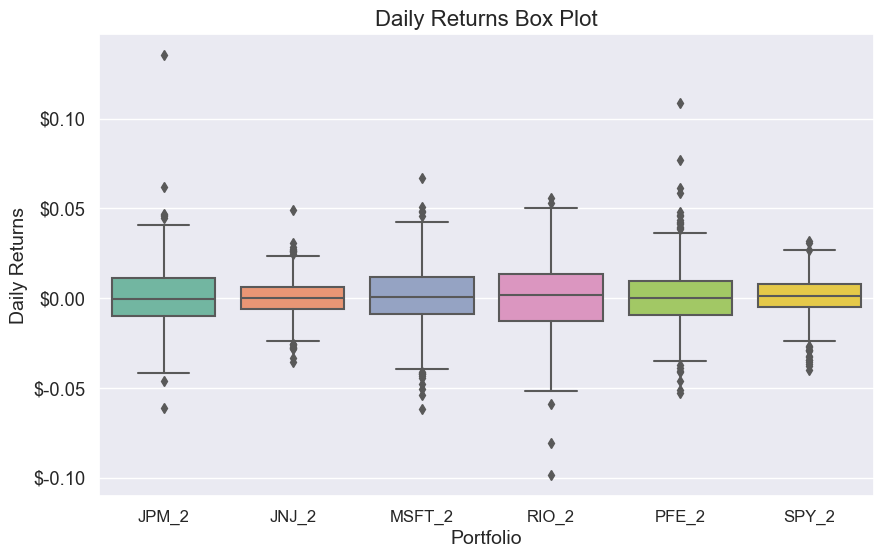

In [462]:
# Create box plot of daily returns for all portfolios
df = df_stock_data[['JPM_2', 'JNJ_2', 'MSFT_2', 'RIO_2', 'PFE_2', 'SPY_2']]
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df, palette="Set2")
ax.set_title('Daily Returns Box Plot', fontsize=16)
ax.set_xlabel('Portfolio', fontsize=14)
ax.set_ylabel('Daily Returns', fontsize=14)

plt.xticks(fontsize=12)
ax.yaxis.set_major_formatter('${x:,.2f}')

# Show the plot
plt.show()

In [463]:
# Calculate cumulative returns
cumulative_returns = (1 + df_stock_data).cumprod() - 1
cumulative_returns

,JPM_2,JNJ_2,MSFT_2,RIO_2,PFE_2,SPY_2
timestamp,,,,,,
2020-08-10 04:00:00+00:00,0.012679,-0.003836,-0.019908,0.010829,-0.001560,0.002959
2020-08-11 04:00:00+00:00,0.044677,-0.010969,-0.042828,0.006563,-0.017165,-0.005231
2020-08-12 04:00:00+00:00,0.035822,0.007133,-0.015484,0.022477,-0.003121,0.008190
2020-08-13 04:00:00+00:00,0.030087,-0.004038,-0.017790,0.013946,-0.007282,0.006695
2020-08-14 04:00:00+00:00,0.030489,-0.002423,-0.016849,0.010500,-0.010143,0.006815
...,...,...,...,...,...,...
2022-08-01 04:00:00+00:00,0.149225,0.170323,0.308405,-0.011485,0.316255,0.227755
2022-08-02 04:00:00+00:00,0.131314,0.163661,0.293392,-0.027071,0.292328,0.219655
2022-08-03 04:00:00+00:00,0.143188,0.174899,0.329396,-0.029040,0.296749,0.238754


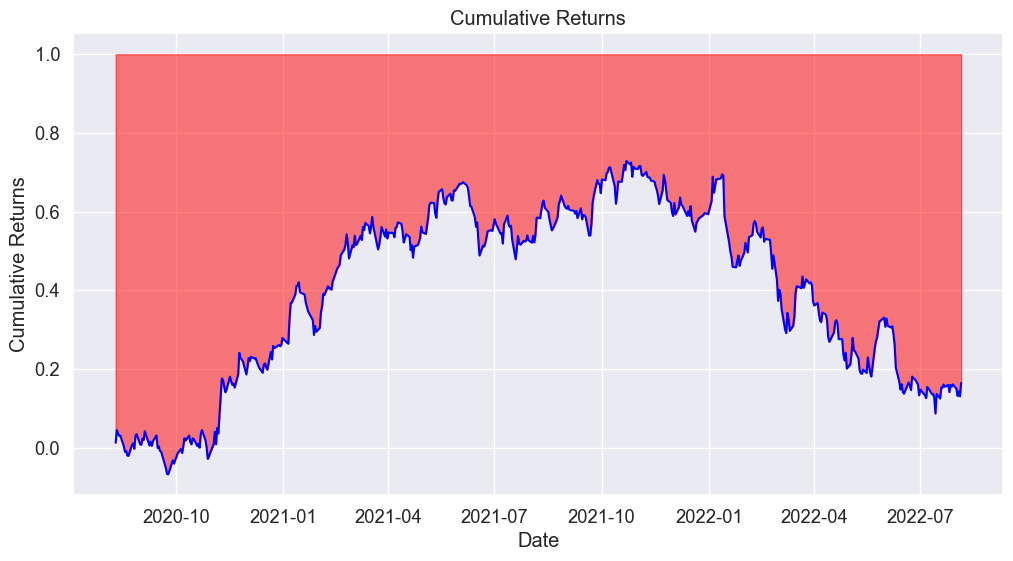

In [464]:
# plot cumulative returns
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cumulative_returns.iloc[:,0], color='blue')

# fill above and below 1
ax.fill_between(cumulative_returns.index, cumulative_returns.iloc[:,0], 1, where=cumulative_returns.iloc[:,0]>=1, interpolate=True, color='green', alpha=0.5)
ax.fill_between(cumulative_returns.index, cumulative_returns.iloc[:,0], 1, where=cumulative_returns.iloc[:,0]<=1, interpolate=True, color='red', alpha=0.5)

# set plot title and axis labels
ax.set_title('Cumulative Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

# show plot
plt.show()

In [465]:
# Calculate the daily standard deviations of all portfolios
daily_std = df_stock_data.std()

# Print the daily standard deviations of all portfolios
print(daily_std)

JPM_2     0.017385
JNJ_2     0.010364
MSFT_2    0.017441
RIO_2     0.020817
PFE_2     0.017229
SPY_2     0.011305
dtype: float64


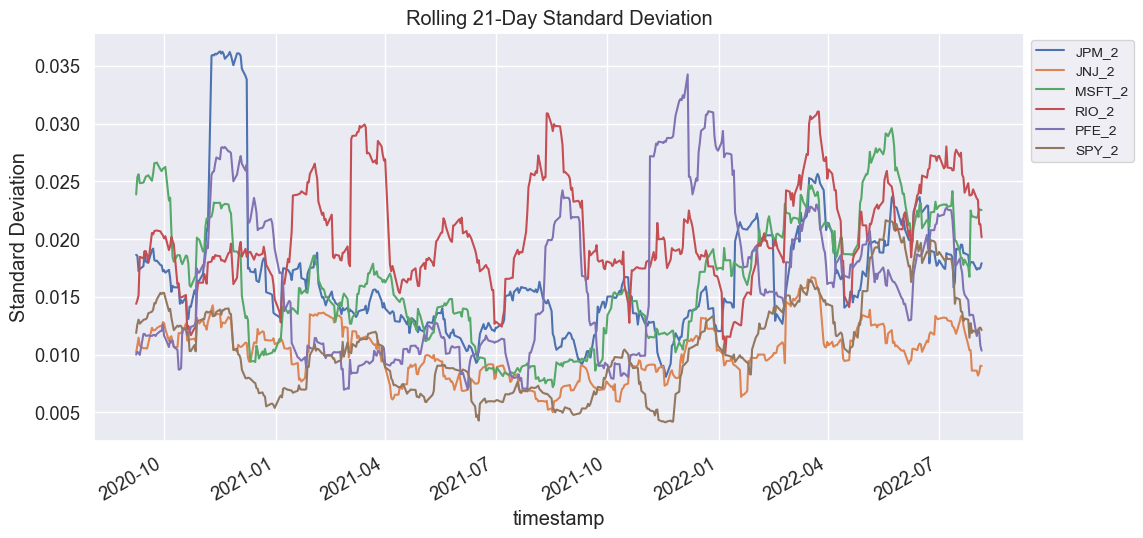

In [466]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
window_size = 21
rolling_std = daily_returns.rolling(window_size).std()

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Set title, x-label, y-label, and grid
ax.set_title('Rolling 21-Day Standard Deviation')
ax.set_xlabel('Date')
ax.set_ylabel('Standard Deviation')
ax.grid(True)

# Plot the rolling standard deviation
rolling_std.plot(ax=ax)

# Add legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Show the plot
plt.show()

In [467]:
# Calculate the annualised standard deviation 
annualised_std = daily_std * np.sqrt(252)
print("Annualised Standard Deviation:")
print(annualised_std)

Annualised Standard Deviation:
JPM_2     0.275973
JNJ_2     0.164516
MSFT_2    0.276872
RIO_2     0.330465
PFE_2     0.273504
SPY_2     0.179454
dtype: float64


In [468]:
# Calculate correlation
correlation = df_stock_data.corr()
correlation

,JPM_2,JNJ_2,MSFT_2,RIO_2,PFE_2,SPY_2
JPM_2,1.000000,0.252177,0.232385,0.401222,0.179491,0.562983
JNJ_2,0.252177,1.000000,0.255869,0.201830,0.412178,0.406363
MSFT_2,0.232385,0.255869,1.000000,0.210150,0.139255,0.808305
RIO_2,0.401222,0.201830,0.210150,1.000000,0.144771,0.417473
PFE_2,0.179491,0.412178,0.139255,0.144771,1.000000,0.246768
SPY_2,0.562983,0.406363,0.808305,0.417473,0.246768,1.000000


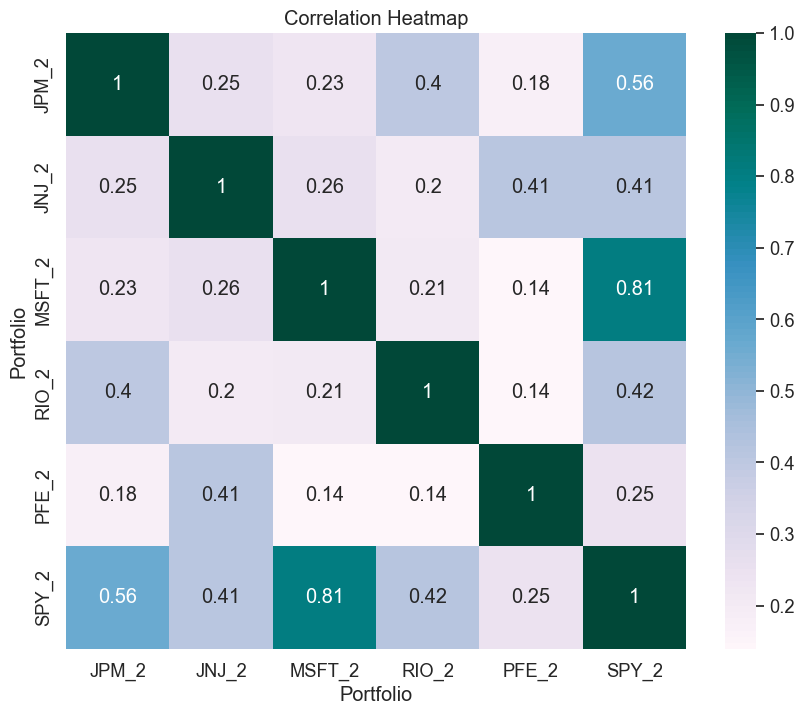

In [469]:
# Plot correlation matrix using heatmap
colors = sns.color_palette("PuBuGn", n_colors=100)

sns.set(font_scale=1.2)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap=colors)
plt.title("Correlation Heatmap")
plt.xlabel('Portfolio')
plt.ylabel('Portfolio')

# Show the plot
plt.show()

In [470]:
# Calculate beta
covariance_matrix = df_stock_data.cov()
JPM_beta = covariance_matrix.loc['JPM_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
JNJ_beta = covariance_matrix.loc['JNJ_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
MSFT_beta = covariance_matrix.loc['MSFT_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
RIO_beta = covariance_matrix.loc['RIO_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
PFE_beta = covariance_matrix.loc['PFE_2']['SPY_2'] / covariance_matrix.loc['SPY_2']['SPY_2']
print(f"JPM beta: {JPM_beta:.2f}")
print(f"JNJ beta: {JNJ_beta:.2f}")
print(f"MSFT beta: {MSFT_beta:.2f}")
print(f"RIO beta: {RIO_beta:.2f}")
print(f"PFE beta: {PFE_beta:.2f}")

JPM beta: 0.87
JNJ beta: 0.37
MSFT beta: 1.25
RIO beta: 0.77
PFE beta: 0.38


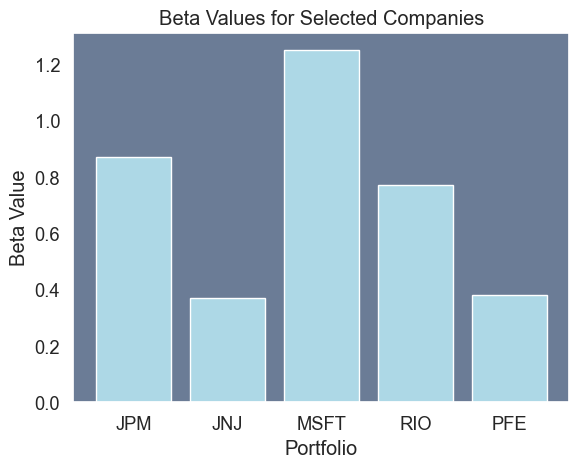

In [471]:
# Define beta values
beta_values = [0.87, 0.37, 1.25, 0.77, 0.38]

# Define company names
company_names = ['JPM', 'JNJ', 'MSFT', 'RIO', 'PFE']

# Show the plot
colors = ['#ADD8E6']
plt.bar(company_names, beta_values, color=colors)
plt.title('Beta Values for Selected Companies')
plt.xlabel('Portfolio')
plt.ylabel('Beta Value')
plt.gca().set_facecolor('#6B7C96')
plt.grid(False)
plt.show()

In [472]:
# Sharpe Ratio
sharpe_ratio = df_stock_data.mean() / df_stock_data.std()
sharpe_ratio

JPM_2     0.026070
JNJ_2     0.032285
MSFT_2    0.041430
RIO_2     0.010034
PFE_2     0.037195
SPY_2     0.042979
dtype: float64

In [473]:
# Annualised Sharpe Ratio
annualised_sharpe_ratio = (df_stock_data.mean() * 252) / (df_stock_data.std() * np.sqrt(252))
annualised_sharpe_ratio

JPM_2     0.413842
JNJ_2     0.512509
MSFT_2    0.657680
RIO_2     0.159291
PFE_2     0.590447
SPY_2     0.682267
dtype: float64

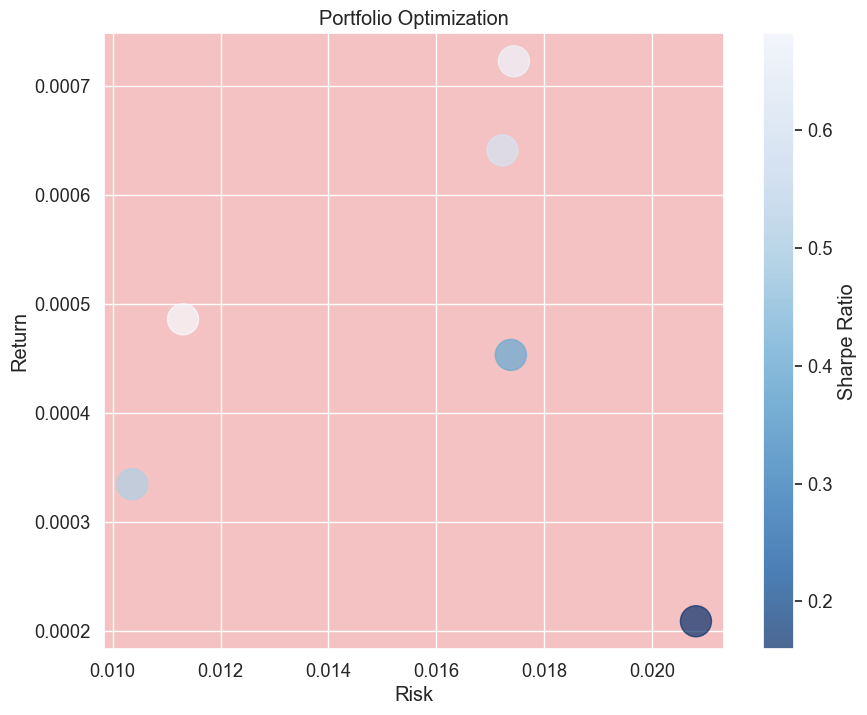

In [474]:
# Visualize the sharpe ratios as a bar plot
#sharpe_ratios.plot(kind='bar', title='Sharpe Ratios')

fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(x=risks, y=returns, c=sharpe_ratios, cmap='Blues_r', alpha=0.7, s=500)

ax.set_xlabel('Risk')
ax.set_ylabel('Return')
ax.set_title('Portfolio Optimization')

cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel('Sharpe Ratio')

ax.set_facecolor('#F4C2C2')

# Show the plot
plt.show()

